# Train and evaluate on MNIST

In [1]:
import sys
sys.path.append('models')

In [2]:
import models.ExampleModels as em
import torch
import matplotlib.pyplot as plt 
import numpy as np

# Get Data

In [3]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torchsummary import summary

In [4]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [5]:
train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

#train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
#valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# Train Model

In [6]:
max_embed_size=80
min_p = .1
ae = em.AutoEncoder(max_embed_size,use_sq_dr= True,dr_min_p= min_p, scale_output=False)


Selected device: cpu


In [7]:
def plot_ae_outputs(ae,n=10): # n = number of embedding size samples
    plt.figure(figsize=(16,4.5))
    encoder = ae.encoder
    decoder = ae.decoder
    device = ae.device
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   


 EPOCH 1/25 	 train loss 0.03876442834734917 	 val loss 0.01853572577238083


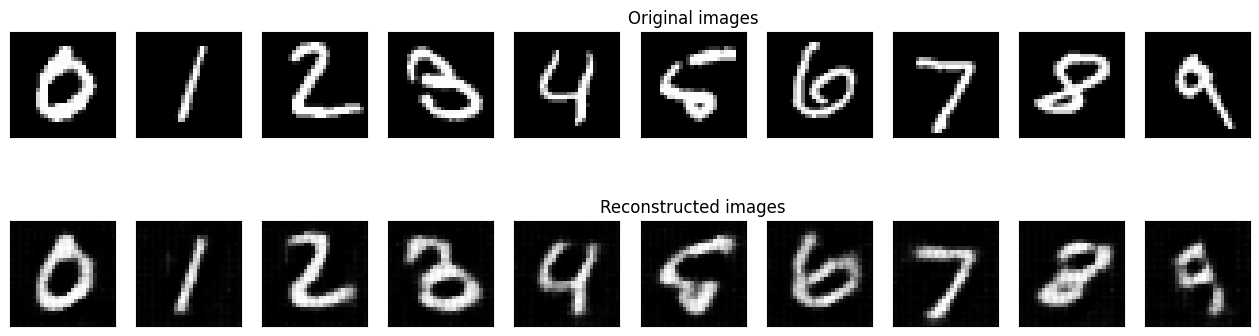


 EPOCH 2/25 	 train loss 0.013912312686443329 	 val loss 0.015515604987740517


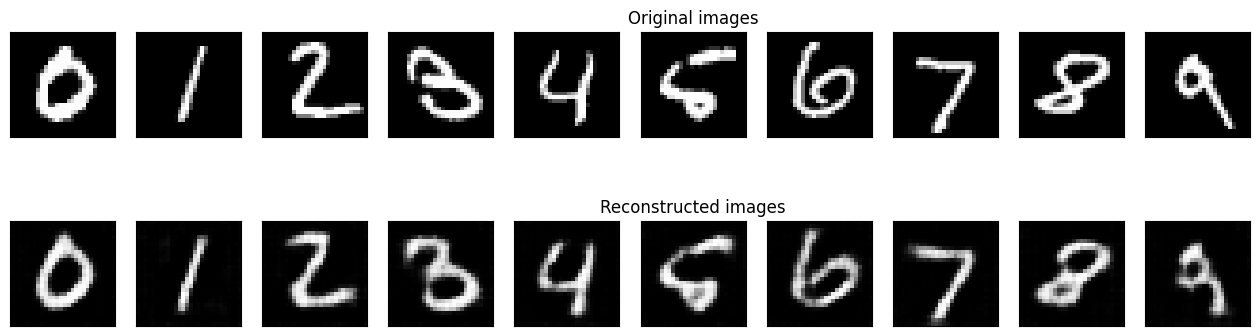


 EPOCH 3/25 	 train loss 0.012142443098127842 	 val loss 0.014925194904208183


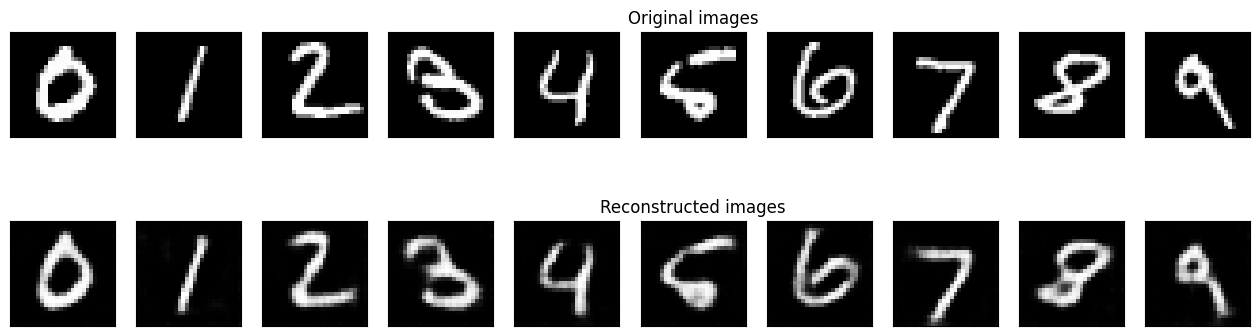


 EPOCH 4/25 	 train loss 0.011427951976656914 	 val loss 0.013951882719993591


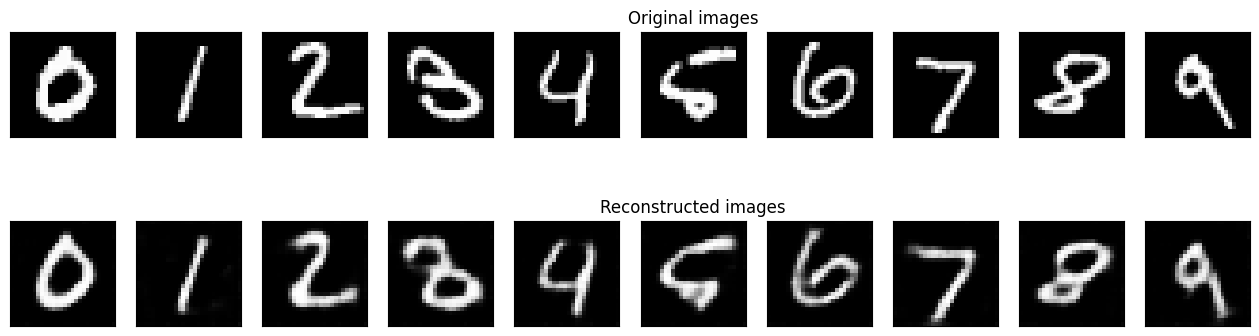


 EPOCH 5/25 	 train loss 0.01073871087282896 	 val loss 0.012848871760070324


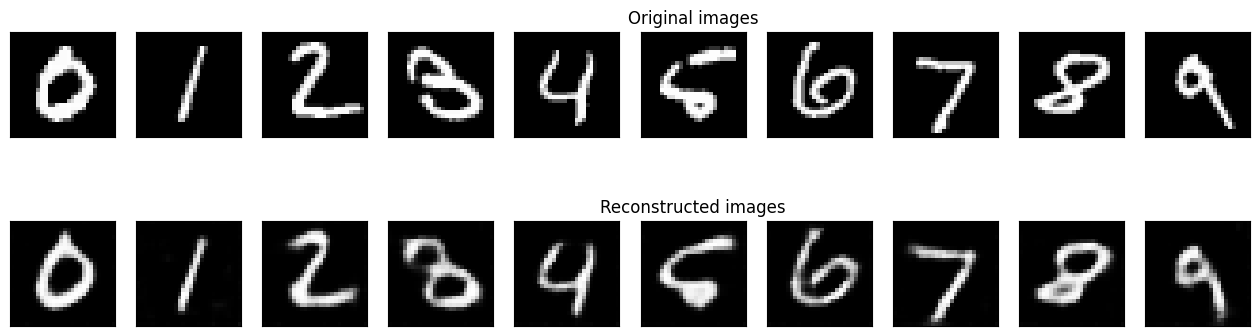


 EPOCH 6/25 	 train loss 0.010387247428297997 	 val loss 0.012460613623261452


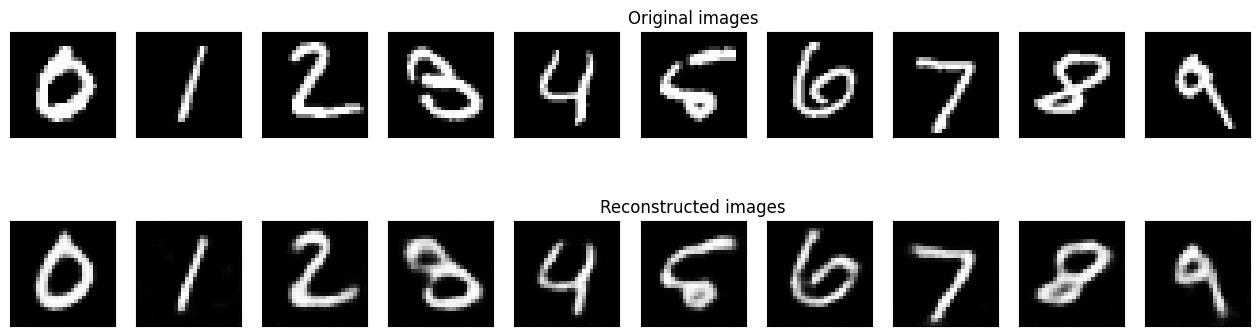


 EPOCH 7/25 	 train loss 0.010140147991478443 	 val loss 0.011734996922314167


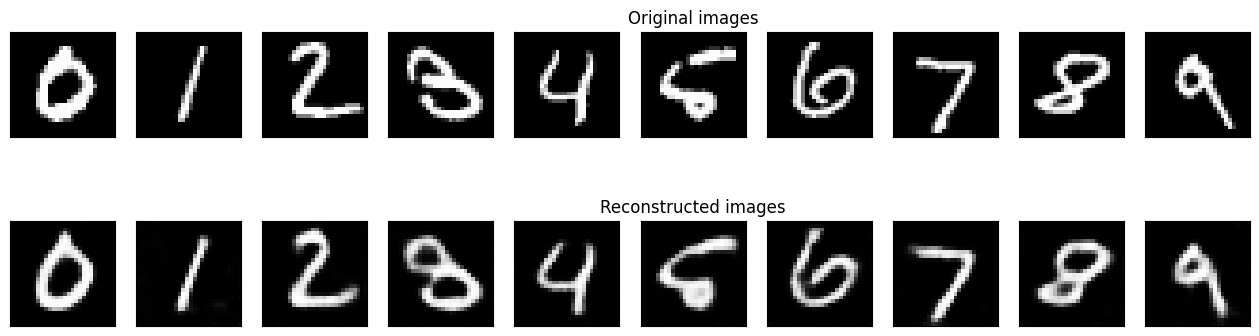


 EPOCH 8/25 	 train loss 0.009806521236896515 	 val loss 0.011916720308363438


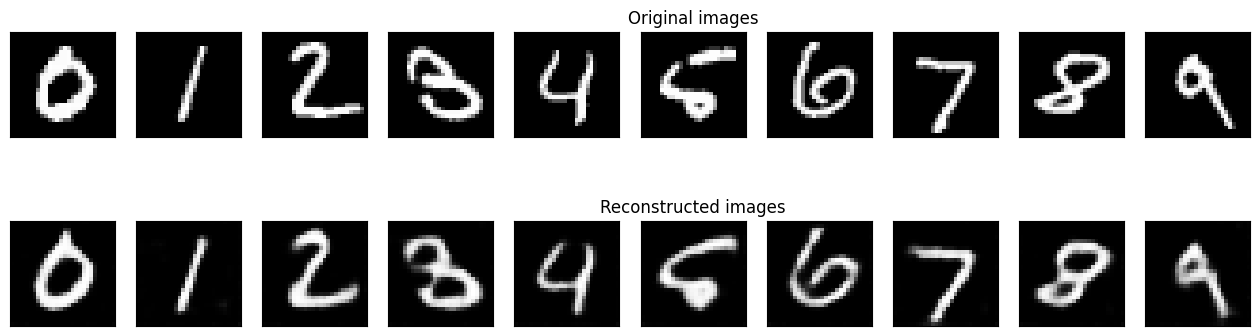


 EPOCH 9/25 	 train loss 0.009760628454387188 	 val loss 0.011822066269814968


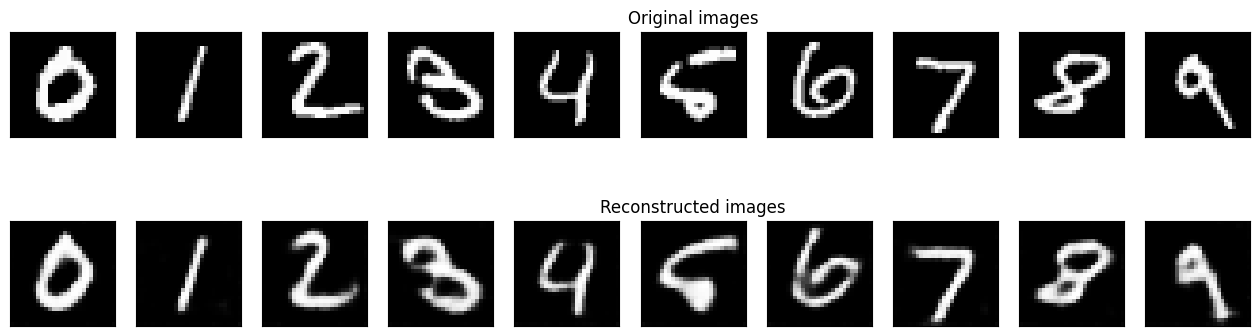


 EPOCH 10/25 	 train loss 0.009469123557209969 	 val loss 0.010340332053601742


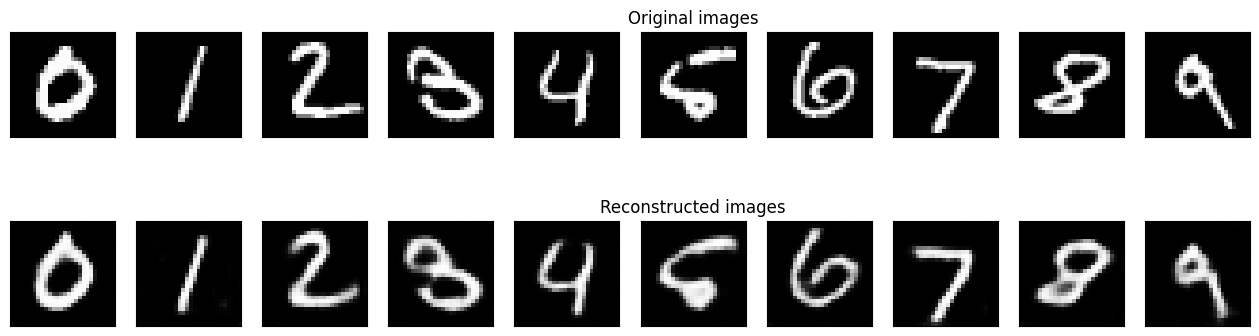


 EPOCH 11/25 	 train loss 0.009494587779045105 	 val loss 0.01274450309574604


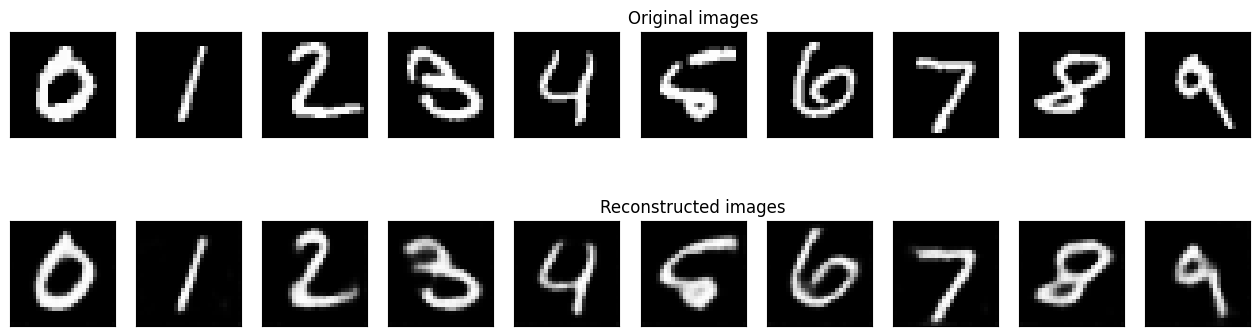


 EPOCH 12/25 	 train loss 0.009281585924327374 	 val loss 0.011106998659670353


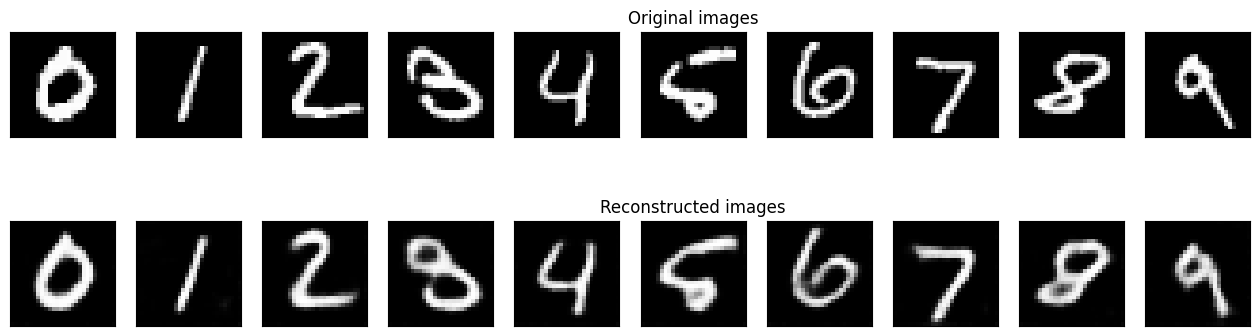


 EPOCH 13/25 	 train loss 0.009352811612188816 	 val loss 0.011376365087926388


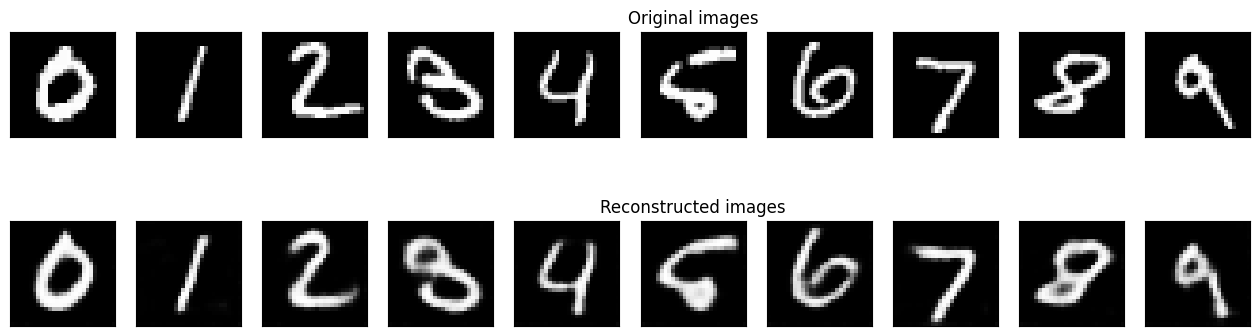


 EPOCH 14/25 	 train loss 0.009134919382631779 	 val loss 0.011266284622251987


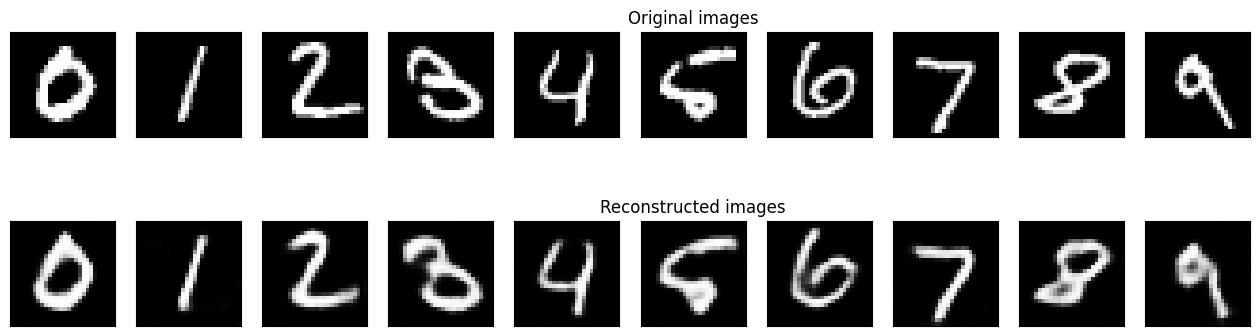


 EPOCH 15/25 	 train loss 0.008892757818102837 	 val loss 0.01187742780894041


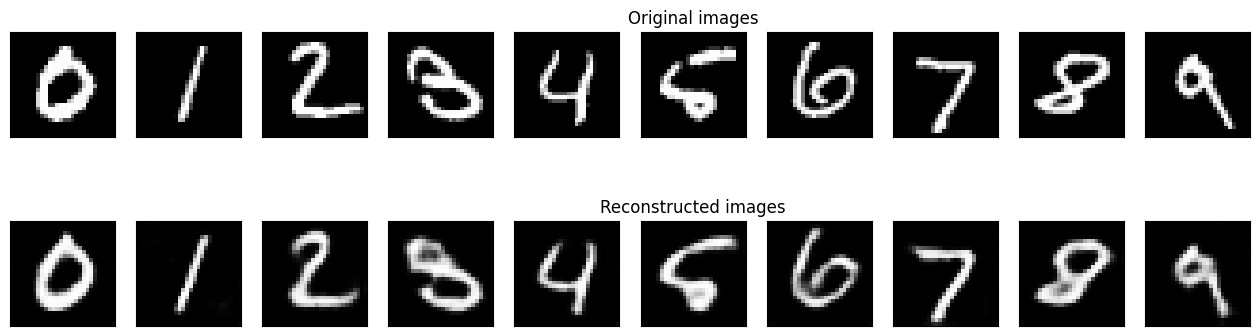


 EPOCH 16/25 	 train loss 0.008966843597590923 	 val loss 0.01102773193269968


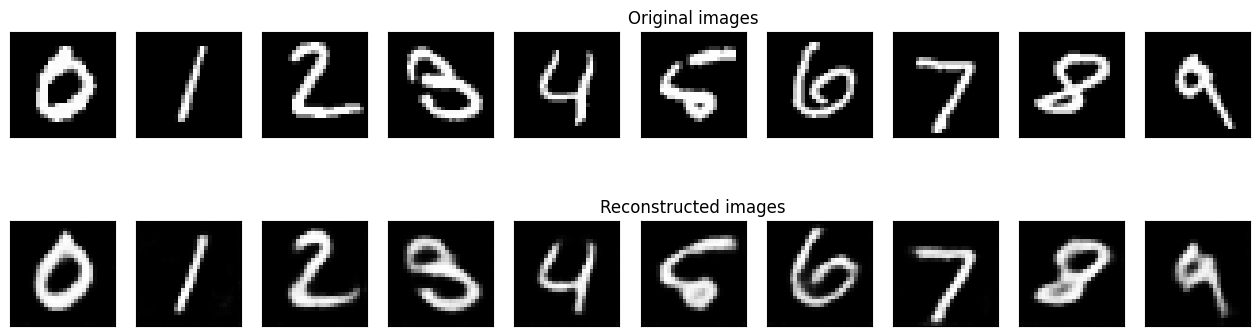


 EPOCH 17/25 	 train loss 0.009082716889679432 	 val loss 0.010723399929702282


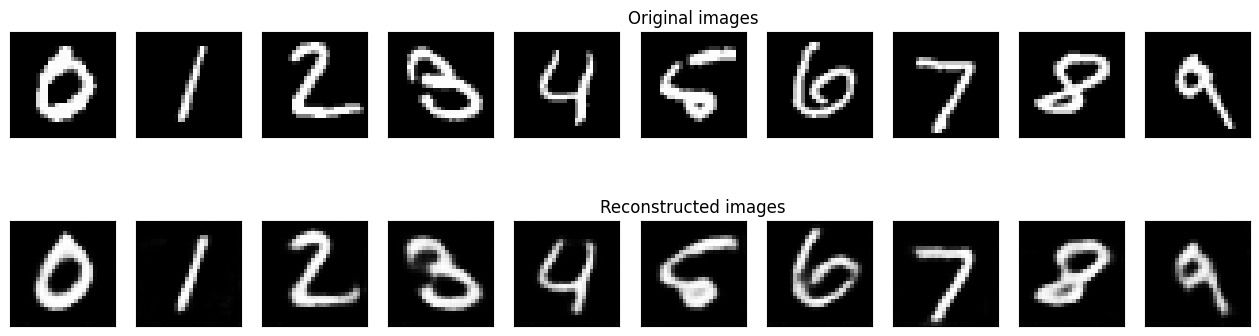


 EPOCH 18/25 	 train loss 0.008889042772352695 	 val loss 0.011907899752259254


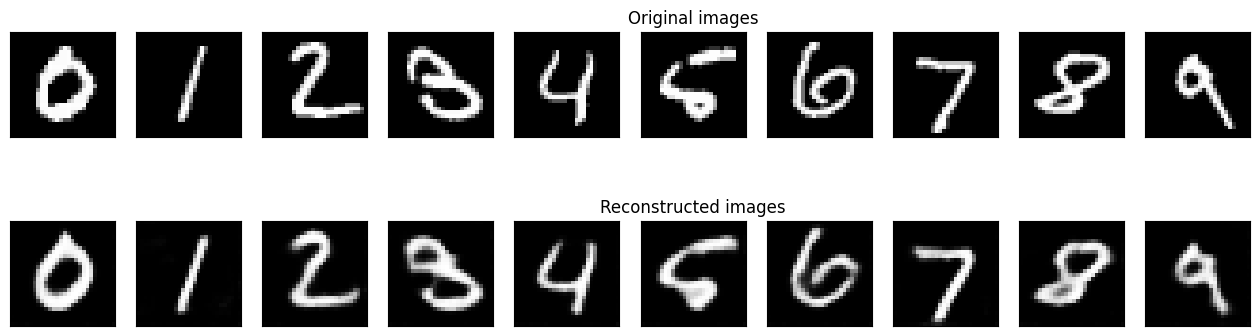


 EPOCH 19/25 	 train loss 0.008865023031830788 	 val loss 0.010966040194034576


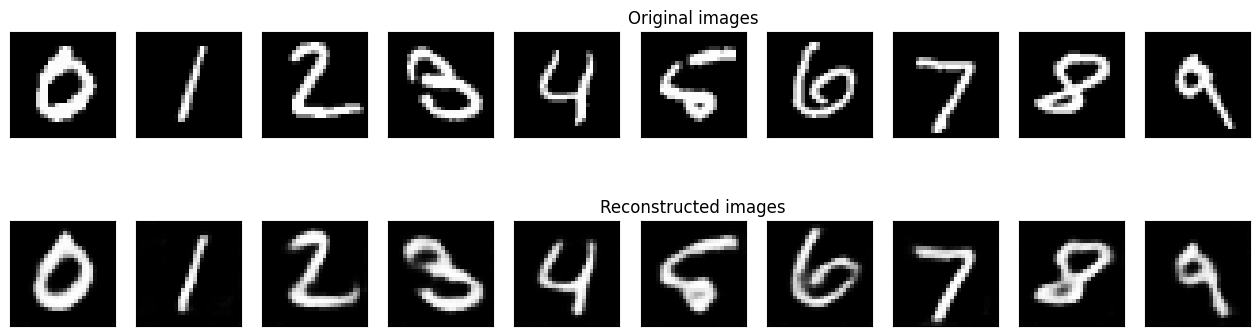


 EPOCH 20/25 	 train loss 0.008745153434574604 	 val loss 0.012135643512010574


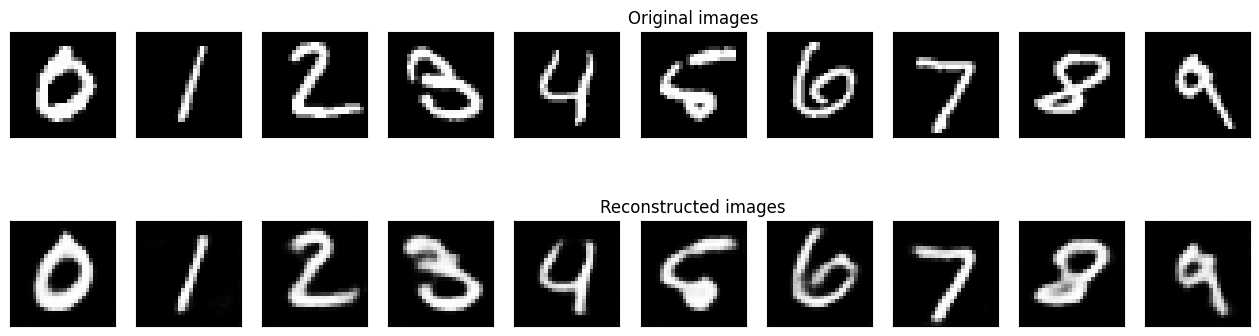


 EPOCH 21/25 	 train loss 0.008889704942703247 	 val loss 0.01124518271535635


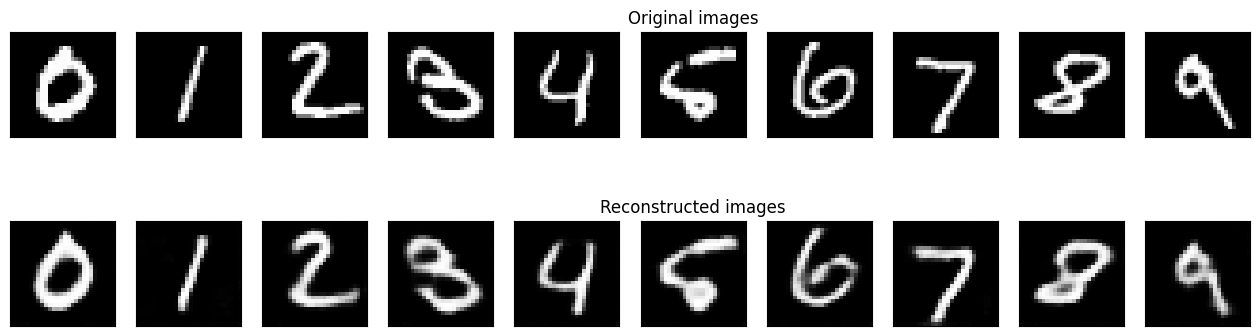


 EPOCH 22/25 	 train loss 0.008708429522812366 	 val loss 0.010360655374825


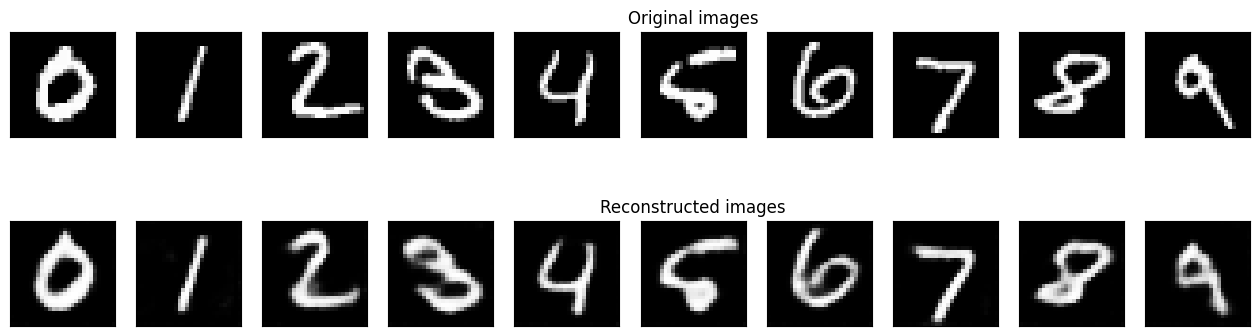


 EPOCH 23/25 	 train loss 0.008842798881232738 	 val loss 0.01105496846139431


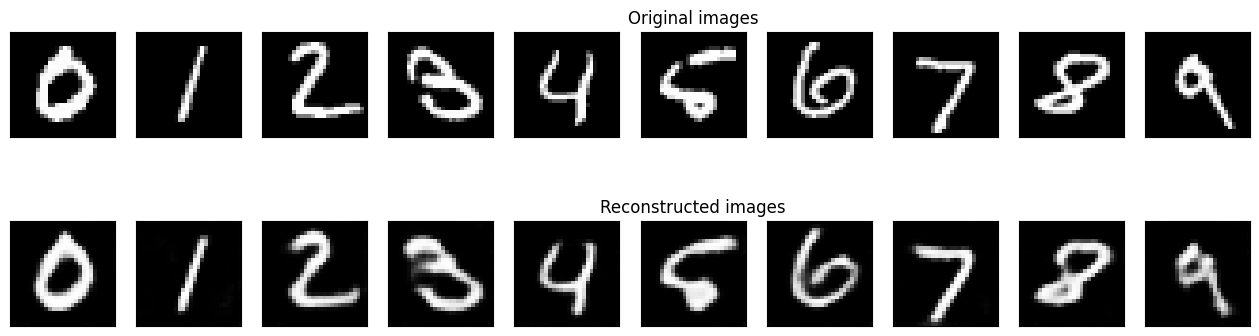


 EPOCH 24/25 	 train loss 0.008532420732080936 	 val loss 0.011568342335522175


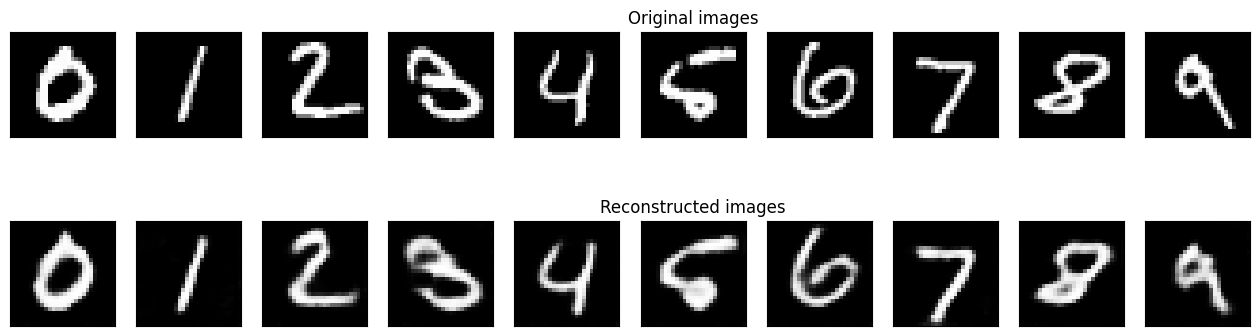


 EPOCH 25/25 	 train loss 0.00851907953619957 	 val loss 0.009739818051457405


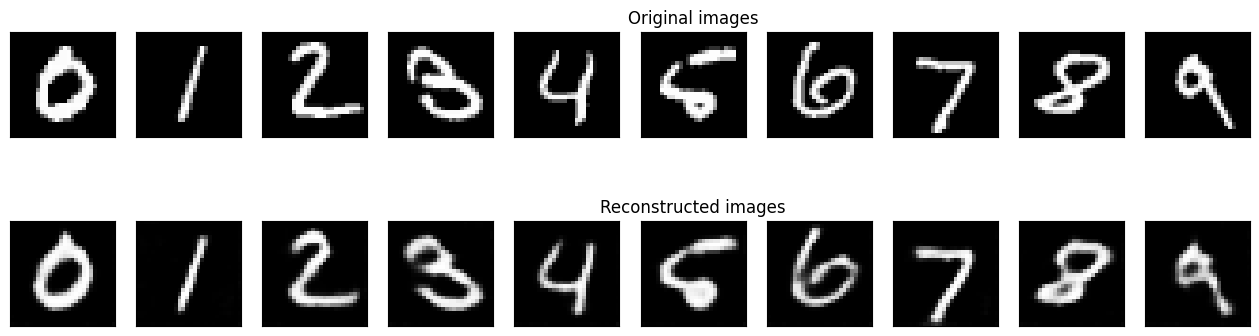

In [8]:
num_epochs = 25
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(ae,n=10)

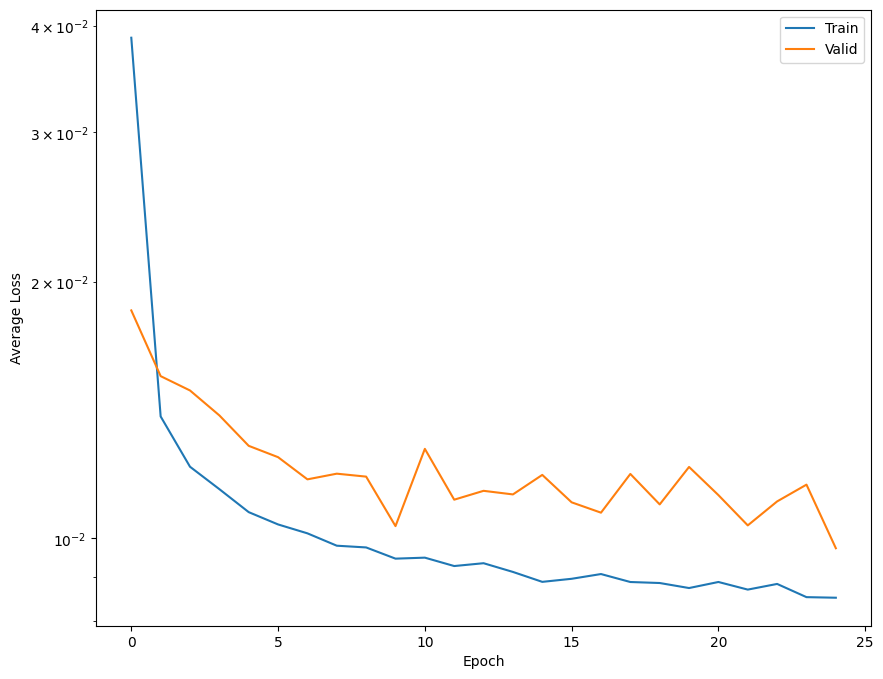

In [9]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# view ablation on an example

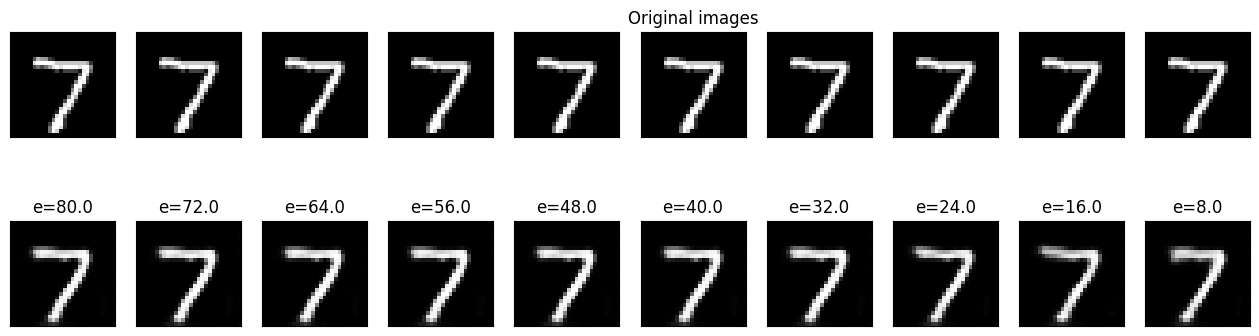

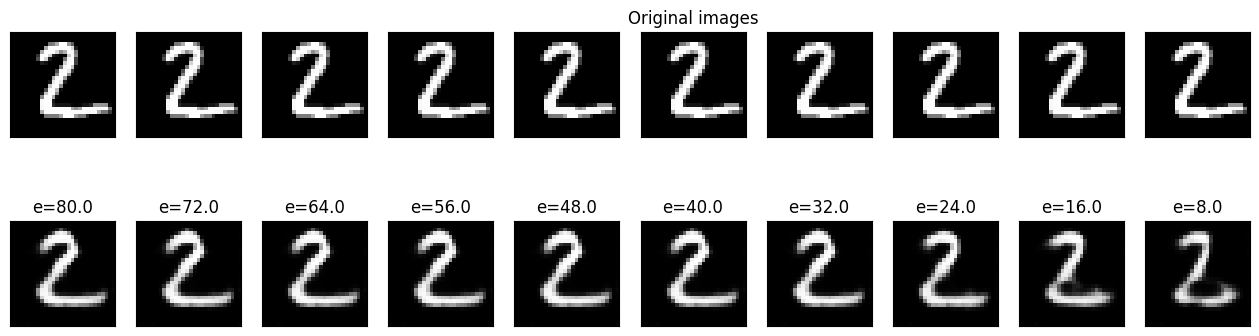

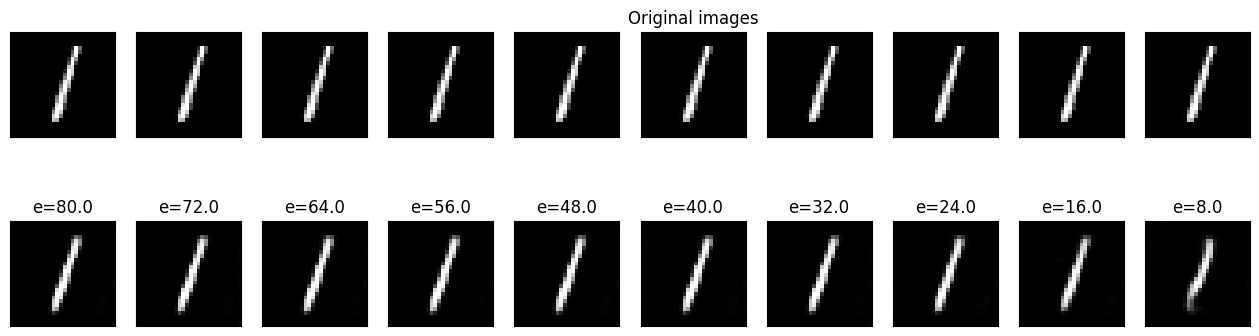

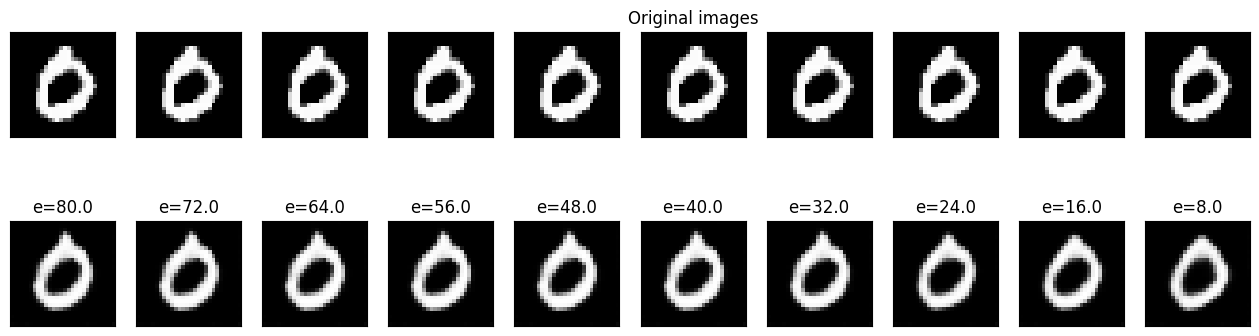

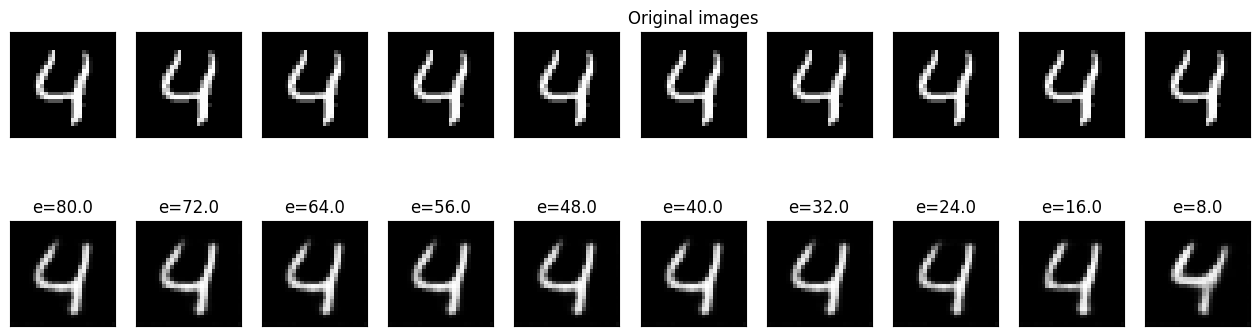

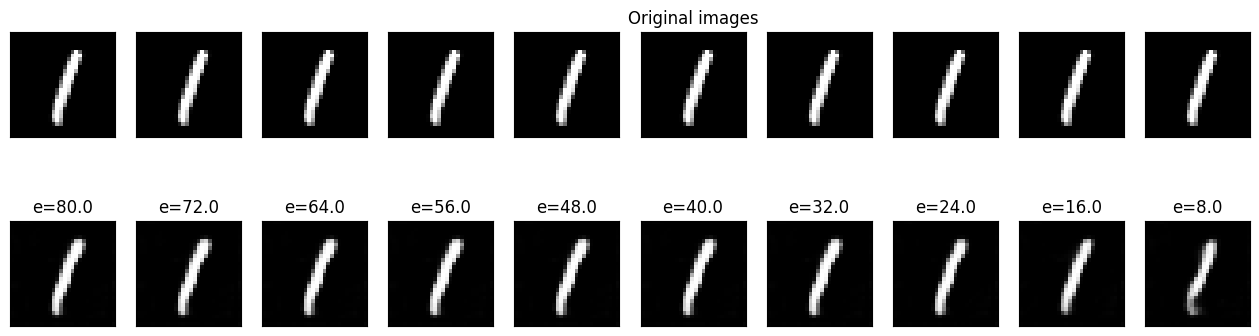

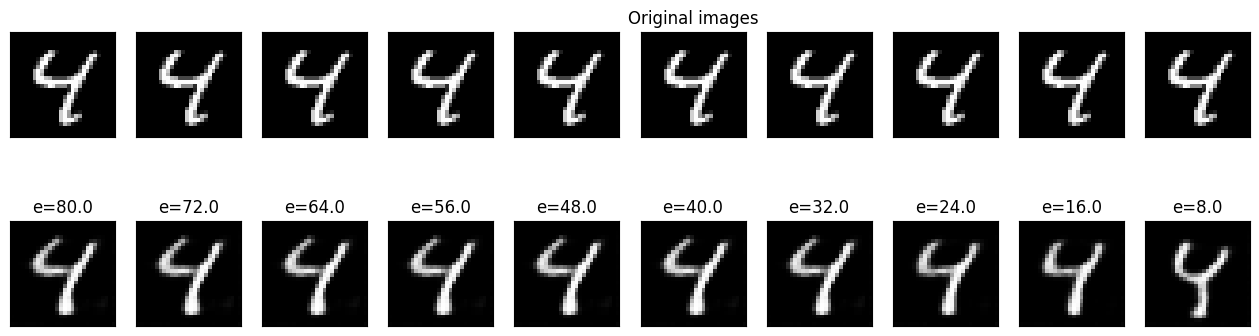

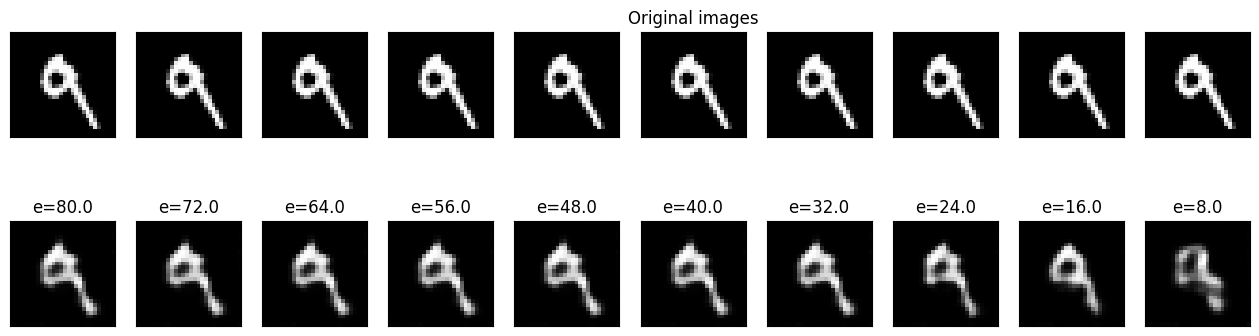

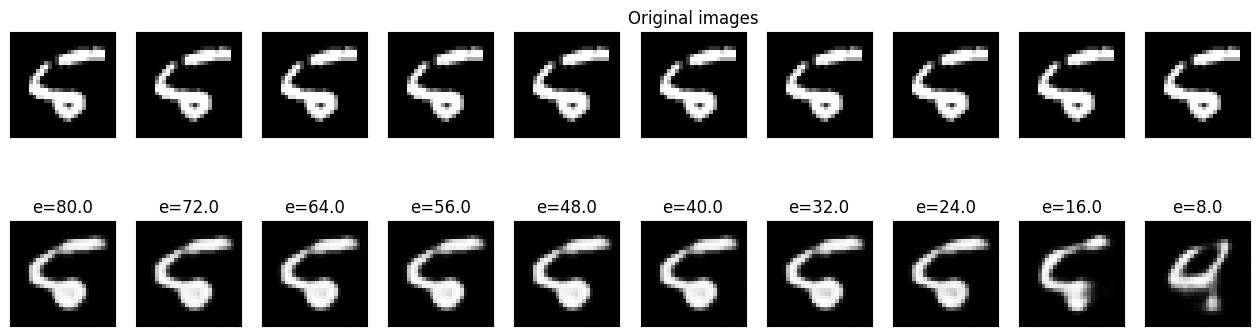

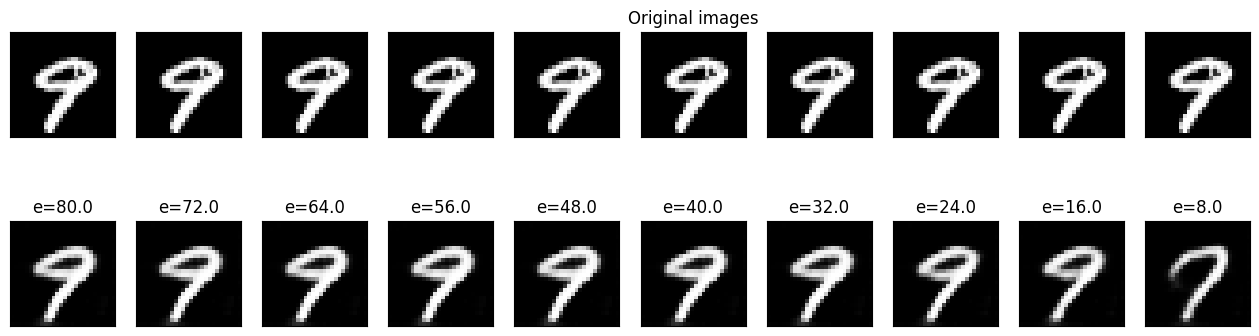

In [10]:
sample_idxs = range(10)
#sample_idx = 1
n = 10
r = np.rint(np.linspace(max_embed_size,int(max_embed_size* min_p),n))

encoder = ae.encoder
decoder = ae.decoder
device = ae.device
encoder.eval()
decoder.eval()
for sample_idx in sample_idxs:
    plt.figure(figsize=(16,4.5))
    img = test_dataset[sample_idx][0].unsqueeze(0).to(device)
    for i, embed_size in enumerate(r):
        
        ax = plt.subplot(2,n,i+1)
        with torch.no_grad():
            # ablate embedding
            embedding = encoder(img)
            #create mask

            if embed_size < embedding.shape[1]:

                embedding[0][-int(embedding.shape[1] - embed_size) :] = 0 

            rec_img  = decoder(embedding)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        #if i == n//2:
        #    ax.set_title('Reconstructed images')
        ax.set_title(f"e={embed_size}")
    plt.show()

# Reconstruction metrics - also compare to reduced precision

In [11]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim # TODO maybe switch this to torchmetrics to run as batch
from skimage.metrics import mean_squared_error


In [12]:
#not currently used
def eval_metric(self, encoder, decoder, dataloader, metric, embed_size):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(self.device)
            # Encode data
            encoded_data = self.encoder(image_batch)
            # Decode data
            decoded_data = self.decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = self.loss_fn(conc_out, conc_label)
    return val_loss.data

In [13]:
#TODO finish me

n = 10
r = np.rint(np.linspace(max_embed_size,int(max_embed_size* min_p),n))

encoder = ae.encoder
decoder = ae.decoder
device = ae.device

# enumerate embedding sizes
avg_psnrs=[]
avg_ssims=[]
avg_mses=[]

#TODO precision eval

for i, embed_size in enumerate(r):
    #enumerate test dataset
    print(i, embed_size)
    psnrs = []
    ssims = []
    mses=[]
    for sample_idx in range(len(test_dataset)):
        img = test_dataset[sample_idx][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            # ablate embedding
            embedding = encoder(img)
            #create mask

            if embed_size < embedding.shape[1]:

                embedding[0][-int(embedding.shape[1] - embed_size) :] = 0 

            rec_img  = decoder(embedding)
        ic= img.cpu().squeeze().numpy()
        
        rc=rec_img.cpu().squeeze().numpy()
        psnrs.append(peak_signal_noise_ratio(ic, rc))
        ssims.append(ssim(ic,rc, data_range=1.0))# 1.0 data range for sigmoid
        mses.append(mean_squared_error(ic,rc))
    avg_psnrs.append(sum(psnrs)/len(psnrs))
    avg_ssims.append(sum(ssims)/len(ssims))
    avg_mses.append(sum(mses)/len(mses))
    

0 80.0
1 72.0
2 64.0
3 56.0
4 48.0
5 40.0
6 32.0
7 24.0
8 16.0
9 8.0


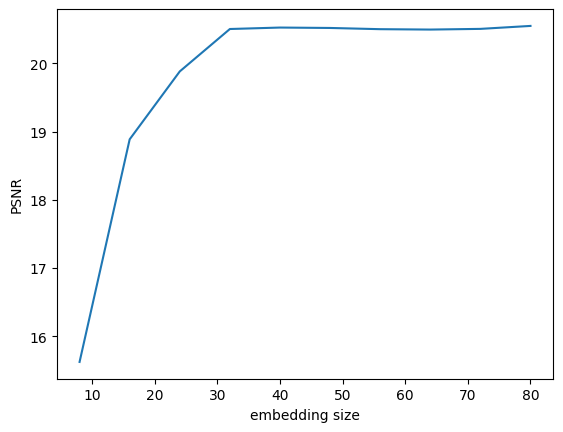

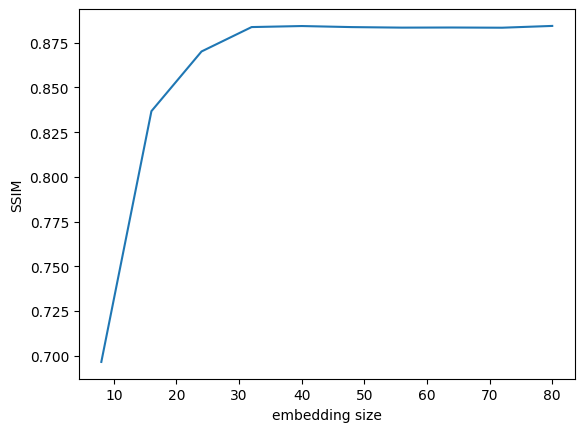

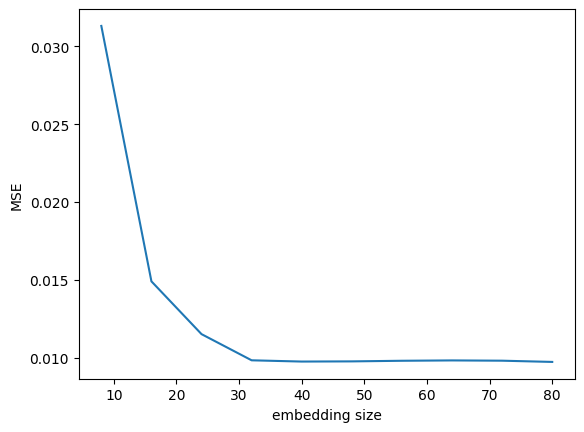

In [14]:
# plot
#i, embed_size = enumerate(r)
plt.plot(r, avg_psnrs)
plt.xlabel("embedding size")
plt.ylabel("PSNR")
plt.show()
plt.plot(r, avg_ssims)
plt.xlabel("embedding size")
plt.ylabel("SSIM")
plt.show()
plt.plot(r, avg_mses)
plt.xlabel("embedding size")
plt.ylabel("MSE")
plt.show()


In [1]:

# around half embedding size it levels off. - tested with 40 and 80 levels off at 30
#todo run tests at different embedding ranges
# run tests at targetted embedding sizes
#todo run precision test
#todo test different embed size sampling ratios
